# Numerai Feature EDA

* Tournament data and example predictions change every week
* Training and validation data only change periodically

---
## Load libraries

In [4]:
# libs
import json
import matplotlib
import numpy as np
import pandas as pd
import random
import sklearn
import matplotlib.pyplot as plt
from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm, ensemble
)
from numerapi import NumerAPI
from utils import (
    save_model, load_model, neutralize, get_biggest_change_features, 
    validation_metrics
)

In [2]:
# see current round
napi = NumerAPI()
current_round = napi.get_current_round()
print(f"Current round #: {current_round}")

Current round #: 312


---
## Review features

In [5]:
# load features.json file
with open("data/features.json", "r") as f:
    feature_metadata = json.load(f)

In [10]:
# view feature keys
feature_metadata["feature_sets"].keys()

dict_keys(['small', 'medium', 'v2_equivalent_features', 'v3_equivalent_features', 'fncv3_features'])

In [11]:
# review small, medium, and other
features_small = feature_metadata["feature_sets"]["small"]
features_medium = feature_metadata["feature_sets"]["medium"]
features_eqv2 = feature_metadata["feature_sets"]["v2_equivalent_features"]
features_eqv3 = feature_metadata["feature_sets"]["v3_equivalent_features"]
features_fncv3 = feature_metadata["feature_sets"]["fncv3_features"]

In [16]:
# length of features
print("Length of small features         :", len(features_small))
print("Length of medium features        :", len(features_medium))
print("Length of v2 equivalent features :", len(features_eqv2))
print("Length of v3 equivalent features :", len(features_eqv3))
print("Length of fncv3 features         :", len(features_fncv3))

Length of small features         : 38
Length of medium features        : 472
Length of v2 equivalent features : 304
Length of v3 equivalent features : 1050
Length of fncv3 features         : 420


---
## Load training data

In [17]:
# read training data
df = pd.read_parquet('data/train.parquet')
df.head()

,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,...,target_paul_v4_20,target_paul_v4_60,target_george_v4_20,target_george_v4_60,target_william_v4_20,target_william_v4_60,target_arthur_v4_20,target_arthur_v4_60,target_thomas_v4_20,target_thomas_v4_60
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,train,1.0,0.50,1.00,1.00,0.00,0.00,1.00,1.00,...,0.50,0.25,0.25,0.00,0.333333,0.000000,0.500000,0.500000,0.166667,0.000000
n003bee128c2fcfc,0001,train,0.5,1.00,0.25,0.75,0.00,0.75,0.50,0.75,...,0.75,1.00,1.00,1.00,0.666667,0.666667,0.833333,0.666667,0.833333,0.666667
n0048ac83aff7194,0001,train,0.5,0.25,0.75,0.00,0.75,0.00,0.75,0.75,...,0.50,0.25,0.25,0.25,0.500000,0.333333,0.333333,0.500000,0.500000,0.333333
n00691bec80d3e02,0001,train,1.0,0.50,0.50,0.75,0.00,1.00,0.25,1.00,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000
n00b8720a2fdc4f2,0001,train,1.0,0.75,1.00,1.00,0.00,0.00,1.00,0.50,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.666667,0.500000,0.666667,0.500000


In [18]:
# check shape
print(f"Shape of the training dataset: {df.shape}")

Shape of the training dataset: (2420521, 1214)


In [19]:
# how many eras?
print(f"Training dataset: {df.shape[0]} rows grouped into {len(df.era.unique())} eras (weeks)")

Training dataset: 2420521 rows grouped into 574 eras (weeks)


---
## Check features & targets

In [20]:
# check features
features = [col for col in df if col.startswith("feature")]
print(f"Number of features: {len(features)}")
print(f"Show first 5 features: {features[:3]}")

Number of features: 1191
Show first 5 features: ['feature_honoured_observational_balaamite', 'feature_polaroid_vadose_quinze', 'feature_untidy_withdrawn_bargeman']


In [21]:
# create era numbers
df["erano"] = df["era"].astype(int)
eras = df["erano"]

In [22]:
# check targets
target = "target"
targets = [col for col in df if col.startswith("target")]
print(f"Number of targets: {len(targets)}")
print(f"Show first 5 targets: {targets[:3]}")

Number of targets: 21
Show first 5 targets: ['target', 'target_nomi_v4_20', 'target_nomi_v4_60']


---
## Evaluation functions

In [23]:
# create numerai_score function
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# regular pearson corr
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

---
## High-level EDA

In [24]:
# check eras
df["era"].min(), df["era"].max()

('0001', '0574')

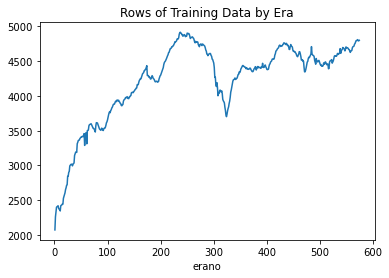

In [25]:
# check data per era
df.groupby(eras).size().plot(title="Rows of Training Data by Era");

In [26]:
# targets are discrete
df.groupby("target").size() / len(df)

target
0.00    0.050007
0.25    0.200001
0.50    0.499975
0.75    0.200014
1.00    0.050003
dtype: float64

In [27]:
# check feature correlations
feature_corrs = df.loc[df["era"]=="0001"][features].corr()
feature_corrs.stack()

feature_honoured_observational_balaamite     feature_honoured_observational_balaamite       1.000000
                                             feature_polaroid_vadose_quinze                 0.002170
                                             feature_untidy_withdrawn_bargeman              0.141514
                                             feature_genuine_kyphotic_trehala               0.171890
                                             feature_unenthralled_sportful_schoolhouse     -0.149952
                                                                                              ...   
feature_polyphyletic_unplumed_pandiculation  feature_marxian_plated_refrigeration           0.945034
                                             feature_amative_irresponsive_flattie           0.951543
                                             feature_intermissive_coronal_reinsertion       0.896336
                                             feature_dwarfish_isochronal_amateur           

In [28]:
# some are very correlated or uncorrelated
tdf = feature_corrs.stack()
tdf = tdf[tdf.index.get_level_values(0) < tdf.index.get_level_values(1)]
tdf.sort_values()

feature_optic_mycelial_whimper                      feature_productile_auriform_fil            -0.950579
feature_careworn_motivational_requisite             feature_loftier_sightly_lyric              -0.940453
feature_dissident_templed_shippon                   feature_rose_buttoned_dandy                -0.939489
feature_applausive_forgettable_mishanter            feature_marled_coliform_proctorship        -0.936837
feature_sodding_choosy_eruption                     feature_utmost_excitable_emir              -0.934667
                                                                                                  ...   
feature_bimanual_godly_witloof                      feature_healthier_unconnected_clave         1.000000
feature_associate_unproper_gridder                  feature_asteriated_invigorated_penitence    1.000000
feature_agricultural_uranic_ankerite                feature_pseudo_bounden_hereafter            1.000000
feature_associate_unproper_gridder                  fea